In [1]:
#LOAD LIBRARIES AND READ DATA
from functions import *
Data=read_data()

# EFFECT OF CHLORIDE ON OXA48'S REACTION RATES

OXA48 is a beta-lactamase that shows biphasic kinetics in the presence of chloride, like these:

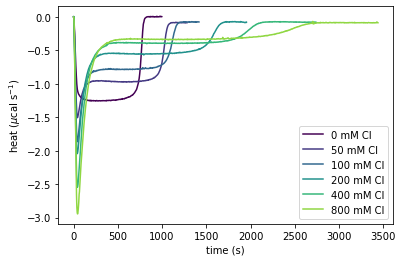

In [2]:
DataCl=Data['Cl']
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
CL=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    ax.plot(D,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
ax.set_xlabel('time (s)');
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)');
ax.legend();
fig.savefig('figures/suppfig_dataCl.pdf', bbox_inches='tight')

Our hypothesis is that, in addition to the usual enzymatic reactions, in the presence of chloride OXA48 undergoes an additional reaction from active enzyme-substrate complex to inactive one. 

The standard enzymatic reactions are as follows:
$$E+S \xrightarrow{k_1} EA \xrightarrow{k_2} E+P+H,$$ 
where $E$ is enzyme, $S$ is substrate, $EA$ is the intermediate enzyme complex, $P$ is product and $H$ is heat released by the reaction. Although these reactions are actually reversible, in practice the kinetic constants are so skewed that we will consider them as irreversible for simplicity. 

In the presence of chloride OXA48 undergoes two additional reactions $C \xrightarrow{k_3} C_2$ and $C_2 \xrightarrow{k_4} C,$ to and from an inactive complex $C_2$ (see main text for more details).

Deriving the corresponding ordinary differential equations from the law of mass action (which is warranted since the number of molecules in the system is very high), we obtain the following system:
\begin{equation}
\begin{aligned}
\frac{dE}{dt} &= -k_1ES+k_2C,\\
\frac{dS}{dt} &= -k_1ES,\\
\frac{dC}{dt} &= k_1ES-k_2C-k_3C+k_4C_2,\\
\frac{dC_2}{dt} &= k_3C-k_4C_2,\\
\frac{dH}{dt} &= -ck_2 C.
\end{aligned}
\end{equation}
Here $c$ is the conversion constant between moles of product and calories of heat. The variable that is measured experimentally in the ITC experiments is a function of $dH/dt$, the instantaneous heat release (see next section).

In what follows we will use mathematical arguments to obtain the different rates involved in these reactions, and in order to discuss the effect chloride has on them.

## Working with the “real” heat curve

The shape of titration curves is affected by the calorimeter response time, as mentioned in [the 2012 kinITC paper by Burnouf et al.](https://pubs.acs.org/doi/10.1021/ja209057d). The signal measured by the calorimeter decreases exponentially with a characteristic time $t_{ITC}$, and so the measured heat release $P_m(t)$ is actually a convolution between the real signal $P_s(t)=dH/dt$ and an exponential kernel $R(t)=(t_{ITC})^{-1} \exp(-t/t_{ITC})$. Thus,
$$P_m(t)=\frac{1}{t_{ITC}} \int_0^t \exp(-(t-\tau)/t_{ITC}) P_s(\tau) \, d\tau,$$
which can be solved either differentiating once or using the Laplace transform, yielding
$$t_{ITC}\frac{dP_m}{dt}+P_m=P_s(t).$$

Given a measured signal $P_m(s)$, we can numerically obtain from this equation the “real” signal that corresponds to our dynamic equations. In our experiments, $t_{ITC}=8\, s$ (see Methods). The result is plotted in the following figure:

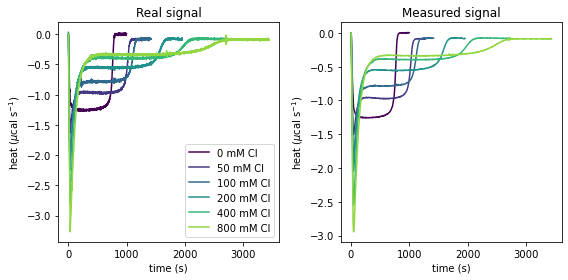

In [3]:
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
cmap=matplotlib.cm.get_cmap('viridis')
CL=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    ax1.plot(realH(D),color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
    ax2.plot(D,'-',color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
ax1.set_xlabel('time (s)');
ax1.set_ylabel('heat ($\mu$cal s$^{-1}$)');
ax2.set_xlabel('time (s)');
ax2.set_ylabel('heat ($\mu$cal s$^{-1}$)');
ax1.set_title('Real signal')
ax2.set_title('Measured signal')
ax1.legend();
fig.tight_layout()
fig.savefig('figures/suppfig_real_vs_measured_signal.pdf', bbox_inches='tight')

The two signals seem very similar, but there are relevant differences especially when there are spikes of heat release, such as at the beginning of the titration experiment:

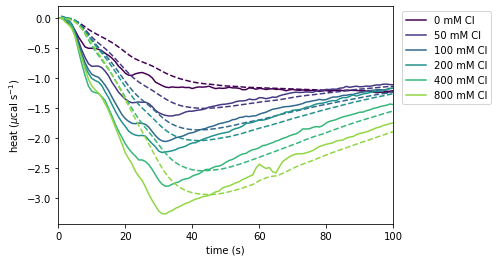

In [4]:
fig=plt.figure()
ax=plt.gca()
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    ax.plot(realH(D),color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
    ax.plot(D,'--',color=cmap(i/len(CL)))
ax.set_xlabel('time (s)');
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)');
ax.legend(bbox_to_anchor=[1.01,1], loc='upper left');
ax.set_xlim([0,100])
fig.savefig('figures/suppfig_real_vs_measured_signal_init.pdf', bbox_inches='tight')

In what follows, we will use the “real” signal $P_s(t)$ to obtain kinetic rates and then use these to simulate our model. In order to compare with the experimental datasets, we will then transform our mathematical variable $dH/dt$ to a measured $P_m$ using the differential equation above.

## Baseline correction

As seen in Figure XXX, the ITC data shows a baseline drift, but we will not correct it as it is hard to do it with our current dataset.

## Dealing with finite time injection of the substrate

A common problem when modeling ITC curves comes from the fact that the injection of the substrate into the chamber is not instantaneous, but rather requires a finite amount of time. Typically, this injection is also combined with some kind of mixing methodology, so that a homogeneous concentration of substrate is quickly attained in all the chamber. Writing this out mathematically is a challenge: ideally we could derive a partial differential equation that would incorporate the diffusion into the chamber, but deriving a mathematical expression for the mixing term seems rather hard. Some ideas have been proposed in the literature (References), but they are far from ideal.

Since our main purpose is to extract OXA48’s reaction rates, we have found a simple, alternative way to model the diffusion of the substrate throughout the ITC chamber by modeling a linear injection of enzyme into the system. The equation for $E$ then becomes
$$\frac{dE}{dt}=\frac{E_T}{k_0}(1-\Theta(t-k_0))-k_1ES+k_2C,$$
where $\Theta(t)$ is the Heaviside function that takes value 0 if $t<0$ and 1 if $t>0$. $k_0$ is the time needed for the substrate to diffuse, and we will set it to values between 20 and 30 seconds depending on the experiment. For instance, using $k_0=30\,s$ for the experiment with different chloride concentrations, we get this figure, which does a good job of capturing this initial injection and mixing.

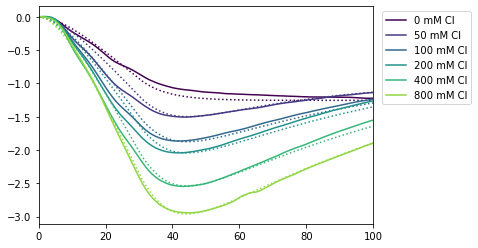

In [5]:
k0=30
k1=1
k3=0.01
E0=100e-3
S0=200
delay=37
CL=[0,50,100,200,400,800]
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    Dr=realH(D)
    c=getc(D,S0)
    k2=getk2(Dr,c,E0)
    k4=getk4(Dr,k3,Cl)
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    tf=len(D)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,k2,C)
    Hs=measuredH(T,H)
    ax.plot(D,'-',color=cmap(i/len(CL)),label=str(CL[i])+' mM Cl')
    ax.plot(T,Hs,ls='dotted',color=cmap(i/len(CL)))
ax.legend(bbox_to_anchor=[1.01,1], loc='upper left')
ax.set_xlim([0,100])
fig.savefig('figures/suppfig_k0.pdf', bbox_inches='tight')

Now we turn to finding out the parameters in our model.

## Finding out $c$

Integrating the area under any of our experimental ITC curves, we obtain the total heat released when all the substrate has been hydrolyzed. We would get the same value by multiplying the initial substrate concentration ($S_0=200 \, \mu M$) times $c$, the conversion rate. So we can estimate $c$ by dividing the total heat released by $S_0$. Using this method in our ITC experiments with different chloride concentrations, we get values of $c$ between 4.5 and 5.5 calories per mole, increasing linearly with chloride concentration. Assuming there is no binding heat from chloride, the variability would then come from an intrinsic drift of the baseline inherent from the ITC method. Therefore, we will use the estimated value of $c$ for each chloride concentration in the following sections.

Cl=0 mM, c= 4.502  cal/M
Cl=50 mM, c= 5.077  cal/M
Cl=100 mM, c= 4.776  cal/M
Cl=200 mM, c= 5.033  cal/M
Cl=400 mM, c= 5.201  cal/M
Cl=800 mM, c= 5.914  cal/M
The fitted equation is 4.7+0.0015*Cl
R^2 is 0.87146


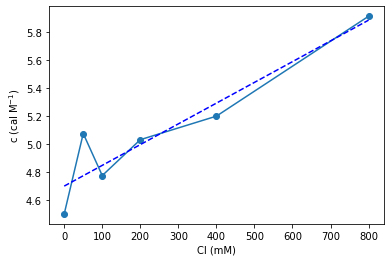

In [6]:
cV=[]
CL=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    mask=D<-0.095
    c2=-auc(D[mask])/200
    c=-auc(D)/200
    cV.append(c)
    print('Cl='+str(Cl),'mM, c=',round(c,3),' cal/M')
    #fig=plt.figure()
    #ax=plt.gca()
    #ax.plot(D[mask])

fig=plt.figure()
ax=plt.gca()
ax.plot(CL,cV,'o-')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('c (cal M$^{-1}$)');
#FIT
from scipy.optimize import curve_fit
def line(x,a,b):
    return a+b*x
popt, pcov = curve_fit(line,CL,cV)
R2=getR2(cV,line(np.array(CL),*popt))
print('The fitted equation is '+str(round(popt[0],2))+'+'+str(round(popt[1],4))+'*Cl')
print('R^2 is '+str(round(R2,5)))
clp=np.linspace(0,800,100)
yp=line(clp,*popt)
ax.plot(clp,yp,'--b');
fig.savefig('figures/suppfig_c_vs_chloride.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame({'Cl (mM)': CL, 'c (cal/M)': cV})
DF.to_excel('results/c_vs_chloride.xls', engine='openpyxl', index=False)

## No chloride: finding out $k_2$

In the absence of chloride, OXA48 follows typical Michaelis-Menten dynamics, as seen before. First, there is a quick increase in heat release, followed by a second stage where heat release is constant (and maximum). If heat release is constant, then as $dH/dt=-ck_2C$ and both $c$ and $k_2$ are constants, $C$ must also be a constant. Therefore, $dC/dt=0$, which implies that $k_1ES=k_2C$. But $E+C=E_T$ is the total enzyme concentration, so solving for $E$ and substituting in the above equation we get
$$k_1E_TS-k_1CS=k_2C \implies C=\frac{k_1E_TS}{k_1S+k_2}=\frac{E_T}{1+\frac{k_2}{k_1S}}.$$
Now, $S \gg E_t$ at this point in the experiment, as initial substrate concentration is $200 \mu M$, while $E_T=100\, nM$, three orders of magnitude less. If we assume $k_1$ and $k_2$ are in the same order of magnitude (an assumption that will be checked later) we deduce from this that, in the constant release stage, almost all the enzyme is in $C$ form.

At this point of maximum heat release, we have 
$$k_2=-\frac{dH/dt}{c C} \approx -\frac{dH/dt}{c E_T}$$ 
and as we know both $c=4.5 cal M^{-1}$  and $E_T=100 nM$ we can derive $k_2$ from measuring the value of $dH/dt$ at the constant heat release stage. For the treatment with no chloride, we get $k_2=2.83 s^{-1}$.

## Estimating the order of magnitude of $k_1$

It is not easy to obtain estimates for $k_1$ from simple mathematical arguments like the previous one. We can, however, perform a numerical fit of the model to the no chloride curve. This yields a value of $k_1=1.06 \,\mu M^{-1} s^{-1}$ and $k_2=2.83 s^{-1}$, confirming our previous argument with a good fit to the data. The actual value of $k_1$ can change between 1 and 1.6 if we allow the minimization routine to vary $k_0$.

Thus, our previous assumption that $k_1$ is of the same order of magnitude as $k_2$ is proven to be true.

The fitted parameters are k1= 1.064  and k2= 2.827


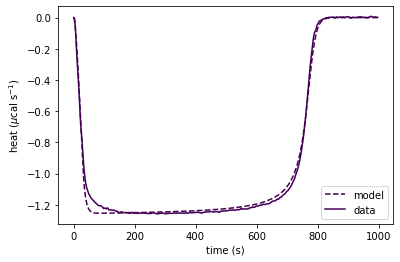

In [8]:
def fun(ParamV,D,c,k0):
    E0=0.1
    S0=200
    tf=len(D)
    y0=[0,S0,0,0]
    Params=Parameters(k0,*ParamV,0,0,0,E0)
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    E=(Hs-D)**2
    return E.mean()

D=DataCl[0].dropna()  
c=4.5
k0=30
res=minimize(fun,[1,2.8],args=(D,c,k0),tol=1e-6,method='Nelder-Mead')
print('The fitted parameters are k1=',round(res.x[0],3),' and k2=',round(res.x[1],3))
E0=0.1#we simulate the model using micro molar concentrations
S0=200
tf=len(D)
y0=[0,S0,0,0]
Params=Parameters(k0,res.x[0],res.x[1],0,0,0,E0)#ParamV[0],ParamV[1],ParamV[2])
sol=solve_ivp(oxa,(0,tf),y0,method='Radau',max_step=0.1,args=((Params,)))
T=sol.t
C=sol.y[2,:]
H=heat(c,Params.k2,C)
Hs=measuredH(T,H)
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
ax.plot(T,Hs,'--',color=cmap(0),label='model')
ax.plot(D,color=cmap(0),label='data')
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
ax.legend()
fig.savefig('figures/suppfig_no_chloride_fit.pdf', bbox_inches='tight')

## The relationship between $k_2$ and chloride

When repeating the experiment with nonzero concentrations of chloride in solution, we find that the maximum heat release increases as chloride increases. As both $c$ and $E_T$ are the same throughout all experimental conditions, it must be the case that $k_2$ is increasing with chloride. We now set to infer the relationship between $k_2$ and chloride concentration.

The maximum heat release in all cases is reached at $t\approx 34\, s$ and by that time the 0 mM chloride treatment has almost reached the maximum heat release. More importantly, simulating our equations with $k_1=1.06 \,\mu M^{-1} s^{-1}$ and $k_2=2.83 s^{-1}$ (as above) by $t=34\, s$ the treatment with no chloride has already reached the maximum heat release. If we assume that $k_1$ is not greatly affected by chloride (we will check this assumption later), we deduce that by $t=34\, s$ almost all of the enzyme is in $C$ form in all treatments. That is 
$$(dH/dt)_{max}=ck_2 E_T \implies k_2=\frac{(dH/dt)_{max}}{c E_T}.$$

The following figure shows a plot of the right-hand side of the last equation against chloride


2.6328582784008683 12727.359861456553 2.851534281371086
R^2 is 0.95574


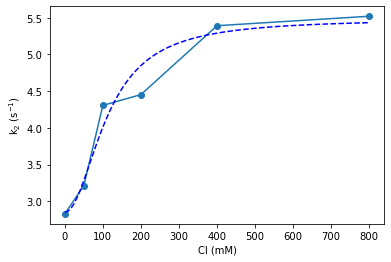

In [7]:
CL=[0,50,100,200,400,800]
K2=[]
E0=100e-3
S0=200
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    rD=realH(D)
    c=getc(rD,S0)
    k2=getk2(rD,c,E0)
    Dmax=(-D).max()
    K2.append(k2)
#PLOT
fig=plt.figure()
ax=plt.gca()
ax.plot(CL,K2,'o-')
#FIT
def hill(x,a,b,c):
    #return a+b*np.log(x-c)#
    return a*x**2/(b+x**2)+c
popt, pcov = curve_fit(hill,CL,K2, p0=[1,-1,-100])
#COMPUTE R SQUARE
R2=getR2(K2,hill(np.array(CL),*popt))
#print('The fitted equation is '+str(round(popt[0],2))+'+'+str(round(popt[1],2))+'*log(x+'+str(-round(popt[2],2))+')')
print(*popt)
print('R^2 is '+str(round(R2,5)))
clp=np.linspace(0,800,100)
yp=hill(clp,*popt)
ax.plot(clp,yp,'--b')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('k$_2$ (s$^{-1}$)');
fig.savefig('figures/suppfig_k2_vs_chloride.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame({'Cl (mM)': CL, 'k2 (1/s)': K2})
DF.to_excel('results/k2_vs_chloride.xls', engine='openpyxl', index=False)

## Finding out $k_3$

After the initial spike in heat release, most of the enzyme is in $C$ state, and suddenly heat starts going down. This is due to the reaction $C\rightarrow C_2$ kicking in, which has rate $k_3$.

Once most of the enzyme is in $C$ state, this means that $dE/dt=0$ and so $k1*E*S= k2*C$, which means that in the equation $dC/dt$ the first two terms are negligible. But also, because there is still no $C_2$ whatsoever, the last term $k_4C_2$ is also close to zero. So at this spike we have $$dC/dt \approx -k_3C.$$

In other words, $C$ will decrease exponentially at a rate $k_3$, very shortly after the spike. Because $dH/dt$ is proportional to $C$, the heat will also decrease exponentially. We can check this by plotting the data in semilog axes: if $dH/dt=A\exp(-k_3t)$, then $\log dH/dt=\log A -k_3t$, and so we should see a linear relationship between $t$ and $\log dH/dt$. This is plotted below:

50 0.00017807485698960132 0.008903742849480065
100 9.160014423639555e-05 0.009160014423639555
200 4.972591067295529e-05 0.009945182134591057
400 2.4805843874495802e-05 0.009922337549798321
800 1.1506323340729687e-05 0.00920505867258375
[9.01353788]
9.981190496316917e-01


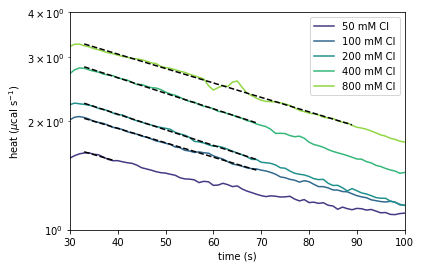

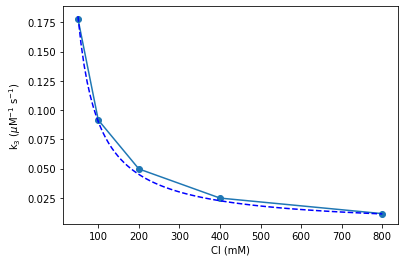

In [33]:
fig=plt.figure()
ax=plt.gca()
CL=[0,50,100,200,400,800]
K3=[]
for i,Cl in enumerate(CL):
    if Cl==0:
        continue
    D=DataCl[Cl].dropna()
    rD=realH(D)
    xinit=33
    xend=70
    if Cl==50:
        xend=40
    if Cl==800:
        xend=90
    xp=range(xinit,xend)
    D1=-rD[xinit:xend]
    popt, pcov = curve_fit(line,xp,np.log(D1))
    yp=line(xp,*popt)
    K3.append(-popt[1]/Cl)
    print(Cl,K3[-1],-popt[1])
    ax.plot(-rD,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
    ax.plot(xp,np.exp(yp),'--k')#,color=cmap(i/len(CL
ax.set_xlim([30,100]);
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
ax.legend()
ax.set_yscale('log')
ax.set_ylim([1,4])
fig.savefig('figures/suppfig_k3_exponential.pdf', bbox_inches='tight')

K3=1000*np.array(K3)
def inverse(x,a):
    return a/(x)
popt, pcov=curve_fit(inverse,CL[1::],K3)
R2=getR2(K3,inverse(np.array(CL[1::]),*popt))
print(popt)
print(R2)
#PLOT
fig=plt.figure()
ax=plt.gca()
ax.plot(CL[1::],K3,'o-')
clp=np.linspace(50,800,100)
yp=inverse(clp,*popt)
ax.plot(clp,yp,'--b')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('k$_3$ ($\mu$M$^{-1}$ s$^{-1}$)');
#ax.set_ylim([0.005,0.015])
fig.savefig('figures/suppfig_k3_vs_chloride.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame({'Cl (mM)': CL[1::], 'k3 (1/s)': K3})
DF.to_excel('results/k3_vs_chloride.xls', engine='openpyxl', index=False)

Black dashed are fits to the equation $dH/dt=A\exp(-k_3t)$, which are visually quite good. 
The values for $k_3$ are between $0.0075$ and $0.01 s^{-1}$ but this variability seems to be due to signal noise: dividing all curves by their maximum value collapses them and shows that $k_3$ is actually independent of chloride (in order to plot in semi log axes, heat is here represented in absolute value).

The treatment with 50mM chloride diverges from the rest of the curves before because in this case $k_4$ is of the same order of $k_3$ (see next section).

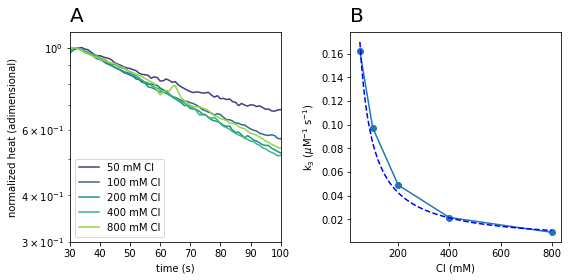

In [38]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,2,1)
CL=[0,50,100,200,400,800]
for i,Cl in enumerate(CL):
    if Cl==0:
        continue
    D=DataCl[Cl].dropna()
    rD=realH(D)
    M=rD.min()
    ax.plot(rD/M,color=cmap(i/len(CL)), label=str(Cl)+' mM Cl')
ax.set_xlim([30,100]);
ax.set_xlabel('time (s)')
ax.set_ylabel('normalized heat (adimensional)')
ax.set_yscale('log')
ax.set_ylim([0.3,1.1])
ax.text(0.0,1.05,'A', fontsize=20, transform=ax.transAxes)
ax.legend()

#PLOT
ax=fig.add_subplot(1,2,2)
ax.plot(CL[1::],K3,'o-')
ax.plot(clp,yp,'--b')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('k$_3$ ($\mu$M$^{-1}$ s$^{-1}$)');
ax.text(0.0,1.05,'B', fontsize=20, transform=ax.transAxes)
#ax.set_ylim([0.005,0.015])
fig.tight_layout()
fig.savefig('figures/suppfig_k3_all_collapse.pdf', bbox_inches='tight')

## The delay in $k_3$

If we simulate our equations as written above, the reaction $C\rightarrow C_2$ will start almost immediately and we get curves that are not similar to the experimental dataset. Thus, we need to assume that this reaction does not start immediately, but only after a delay of around 37 seconds. $k_3$ is then set to zero in our equations if $t<37\, s$.

## Finding out $k_4$

Now, although the curves start going down at the same speed, they soon diverge. This is because, as $C_2$ starts to increase, the previous approximation $dC/dt \approx -k_3C$ is no longer valid and the change in heat is no longer exponential —which can be appreciated because the curves are no longer linear in the semilog plot. 

The curves eventually reach a new stationary value $(dH/dt)_s$, where $k_3(C)_s=k_4(C_2)_s$. At this point almost all the enzyme is in either $C$ or $C_2$ form, and so $(C)_s+(C_2)_s=E_T$. From these two equations we see that $k_4=k_3\frac{C_s}{E_T-C_s}$
and so we only need to obtain $C_s$. That is done by measuring the stationary value $(dH/dt)_s=ck_2C_s$, which leads us to
$$k_4=k_3\frac{(dH/dt)_s}{ck_2E_T-(dH/dt)_s}.$$
But $ck_2E_t=(dH/dt)_\max$ and so finally we have
$$k_4=k_3\frac{(dH/dt)_s}{(dH/dt)_\max-(dH/dt)_s}.$$
That is, finding out $k_4$ depends only on the value of $dH/dt$ at its peak ($(dH/dt)_\max$) and the value of $dH/dt$ at the plateau ($(dH/dt)_s$). Using this formula with $k_3=0.01 \mu M^{-1} s^{-1}$, we obtain the following inverse relationship between $k_4$ and chloride:

50 0.011854722014593451
100 0.006004541122023369
200 0.0031663906282095606
400 0.0014045749939328076
800 0.0008316660521996612
0.5959372663051864
The fitted equation is 0.596/Cl
R^2 is 0.99931


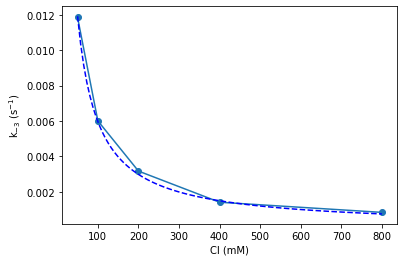

In [42]:
CL=[50,100,200,400,800]
K4=[]
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    rD=realH(D)
    k4=getk4(rD,K3[i]*Cl/1000,Cl)
    K4.append(k4)
    print(Cl,k4)
#FIT
def inverse(x,a):
    return a/(x)
popt, pcov=curve_fit(inverse,CL,K4)
print(*popt)
#COMPUTE R SQUARE
R2=getR2(K4,inverse(np.array(CL),*popt))
print('The fitted equation is '+str(round(popt[0],3))+'/Cl')
print('R^2 is '+str(round(R2,5)))
#PLOT
fig=plt.figure()
ax=plt.gca()
ax.plot(CL,K4,'o-')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('k$_{-3}$ (s$^{-1}$)')
clp=np.linspace(50,800,100)
yp=inverse(clp,*popt)
ax.plot(clp,yp,'--b')
fig.savefig('figures/suppfig_k4_vs_chloride.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame({'Cl (mM)': CL, 'k_{-3} (1/s)': K4})
DF.to_excel('results/k4_vs_chloride.xls', engine='openpyxl', index=False)

## The relationship between $k_1$ and chloride

As pointed out before, there is no easy way to obtain information about $k_1$ from the equations, and therefore we have turned to numerical optimization. We have fitted the parameters of each of the ITC curves using standard numerical routines in Python, obtaining very similar results to the ones described above. The following figure plots each data curve and two simulations of the model, one obtained using our analytic approximations (dotted lines) and the other using the numerical fit (dashed lines). The agreement between them is very good.

0 0



KeyboardInterrupt



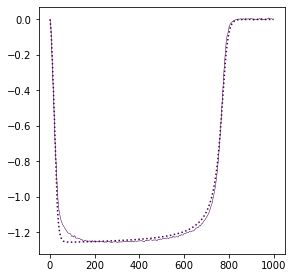

In [26]:
def fun(ParamV,D,Cl):
    E0=0.1
    S0=200
    c=ParamV[0]
    tf=len(D)
    y0=[0,S0,0,0]
    Params=Parameters(*ParamV[1::],E0)
    if Cl==0:
        Params.k3=0
        Params.k4=0
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    E=(Hs-D)**2
    return E.mean()

fig=plt.figure(figsize=(15,10))
cmap=matplotlib.cm.get_cmap('viridis')
E0=100e-3
S0=200
CL=[0,50,100,200,400,800]
AP=[]
P=[]
for i,Cl in enumerate(CL):
    ax=fig.add_subplot(2,3,i+1)
    D=DataCl[Cl].dropna()
    ax.plot(D,lw=0.5,color=cmap(i/len(CL)),label=str(CL[i])+' mM Cl')
    rD=realH(D)
    c=getc(D,S0)
    k0=30
    k1=1.05
    k2=getk2(rD,c,E0)
    k3=0.01
    if Cl==0:
        k3=0
    k4=getk4(rD,k3,Cl)
    delay=37
    AP.append([Cl,c,k0,k1,k2,k3,k4,delay])
    tf=len(D)
    y0=[0,S0,0,0]
    #Approx sim
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',max_step=0.5,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dotted',color=cmap(i/len(CL)), label='approx')
    #Fitted sim
    res=minimize(fun,[c,k0,k1,k2,k3,k4,delay],args=(D,Cl),tol=1e-6,method='Nelder-Mead')
    P.append([Cl,*res.x])
    Params=Parameters(*res.x[1::],E0)#ParamV[0],ParamV[1],ParamV[2])
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',max_step=0.5,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(res.x[0],Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(CL)), label='numerical fit')
    ax.legend()
    ax.set_xlabel('time (s)')
    ax.set_ylabel('heat ($\mu$cal s$^{-1}$)')
fig.tight_layout()
fig.savefig('figures/suppfig_approx_vs_fitted.pdf', bbox_inches='tight')

#SAVE PARAMETERS
DF=pd.DataFrame.from_records(P, columns=['Cl','c','k0','k1','k2','k3','k4','delay'])
DF.to_csv('results/chloride_fit.csv', float_format='%.4f', index=False)
DF=pd.DataFrame.from_records(AP, columns=['Cl','c','k0','k1','k2','k3','k4','delay'])
DF.to_csv('results/chloride_approx.csv', float_format='%.4f', index=False)

From this, we can now find out if there is a relationship between $k_1$ and chloride. The numerical fits yield the following figure. Therefore, there is no relationship between $k_1$ and chloride: changes of this parameter between values of $1.04$ and $1.10$ do not lead to significant changes in our simulations, and so these differences can be disregarded (and furthermore, these values of $k_1$ will change depending on the initial conditions of the fit.

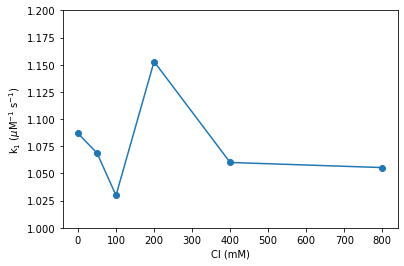

In [18]:
DF=pd.read_csv('results/chloride_fit.csv')
CL=DF['Cl']
K1=DF['k1']
fig=plt.figure()
ax=plt.gca()
ax.plot(CL,K1,'o-')
ax.set_xlabel('Cl (mM)')
ax.set_ylabel('k$_1$ ($\mu$M$^{-1}$ s$^{-1}$)')
ax.set_ylim([1,1.2])
fig.savefig('figures/suppfig_k1_vs_chloride.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame({'Cl (mM)': CL, 'k1': K1})
DF.to_excel('results/k1_vs_chloride.xls', engine='openpyxl', index=False)

With this information, we can now use our model to simulate our datasets.

# Simulating all experiments

## Different chloride concentrations

0 0
50 0.008114637546487747
100 0.009646981236593107
200 0.009493036611121204
400 0.009253093456130658
800 0.007830627210217322


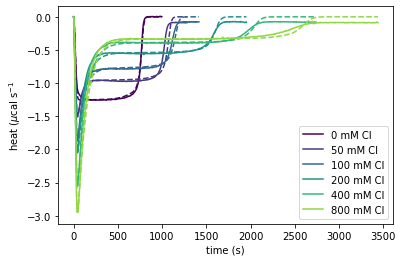

In [34]:
#SIMULATE CL DATA
E0=100e-3
S0=200
CL=[0,50,100,200,400,800]
k0=30
k1=1.05
k3=0.01
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
DFmap={}
DFmap['Time']=np.array(range(len(DataCl[800].dropna())))+60
for i,Cl in enumerate(CL):
    D=DataCl[Cl].dropna()
    rD=realH(D)
    c=getc(D,S0)
    k2=getk2(rD,c,E0)
    k3=0.01
    k3=getk3(rD,Cl)
    print(Cl,k3)
    k3=0.009
    k4=getk4(rD,k3,Cl)
    if Cl==0:
        k3=0
        k4=0
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    tf=len(D)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='RK45',t_eval=range(tf),max_step=1,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(CL)))
    ax.plot(D,color=cmap(i/len(CL)), label=str(CL[i])+' mM Cl')
    DFmap[Cl]=Hs
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataCl.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in DFmap.items() ]))
DF.to_excel('results/dataCl.xls', engine='openpyxl', index=False)

## Different substrate concentrations

Here the chloride concentration has been fixed to 100 mM, and so we will use the parameters we found out before for this concentration.

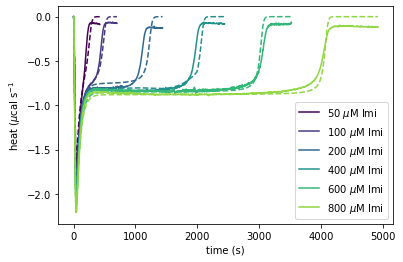

In [29]:
#SIMULATE S DATA
DataS=Data['S']
E0=100e-3
Cl=100
ST=[50,100,200,400,600,800]
c=4.78
k0=25
k1=1.05
k3=0.01
k4=0.006
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
DFmap={}
DFmap['Time']=np.array(range(len(DataS[800].dropna())))+60
for i,S0 in enumerate(ST):
    D=DataS[S0].dropna()
    rD=realH(D)
    c=getc(D,S0)
    k2=getk2(rD,c,E0)
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    tf=len(D)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='RK45',t_eval=range(tf),max_step=0.1,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(ST)))
    ax.plot(D,color=cmap(i/len(ST)), label=str(ST[i])+' $\mu$M Imi')
    DFmap[S0]=Hs
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataS.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in DFmap.items() ]))
DF.to_excel('results/dataS.xls', engine='openpyxl', index=False)

## Different enzyme concentrations

We have two different datasets for this. In this case we need to recalculate $k_3$ as the quality of the enzyme was not as good as in the other datasets.

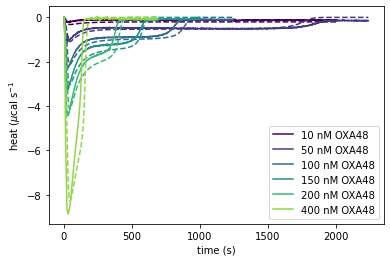

In [9]:
#SIMULATE E DATA
DataE=Data['E']
S0=200
Cl=100
ET=[10,50,100,150,200,400]
c=4.78
k0=25
k1=1.05
#k3=0.01
k4=0.006
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
DFmap={}
DFmap['Time']=np.array(range(len(DataE[10].dropna())))+60
for i,E0 in enumerate(ET):
    D=DataE[E0].dropna()
    E0/=1000#we simulate the model in micro molar
    rD=realH(D)
    k2=getk2(rD,c,E0)
    k3=getk3(rD,Cl)
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    tf=len(D)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='RK45',t_eval=range(tf),max_step=0.1,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(ET)))
    ax.plot(rD,color=cmap(i/len(ET)), label=str(ET[i])+' nM OXA48')
    DFmap[E0]=Hs
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataE.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in DFmap.items() ]))
DF.to_excel('results/dataE.xls', engine='openpyxl', index=False)

# DIFFERENT E CONCENTRATIONS (2)

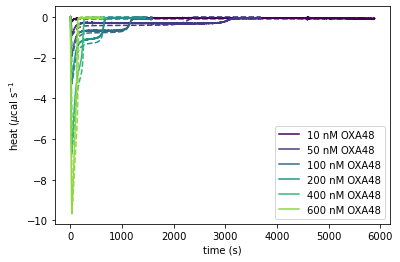

In [10]:
#SIMULATE E DATA (2)
DataE2=Data['E2']
S0=200
Cl=100
ET=[10,50,100,200,400,600]
c=4.78
k0=25
k1=1.05
#k3=0.01
k4=0.006
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
DFmap={}
DFmap['Time']=np.array(range(len(DataE2[10].dropna())))+60
for i,E0 in enumerate(ET):
    D=DataE2[E0].dropna()
    E0/=1000#we simulate the model in micro molar
    rD=realH(D)
    k2=getk2(rD,c,E0)
    k3=getk3(rD,Cl)
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    tf=len(D)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='RK45',t_eval=range(tf),max_step=0.1,args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(ET)))
    ax.plot(rD,color=cmap(i/len(ET)), label=str(ET[i])+' nM OXA48')
    DFmap[E0]=Hs
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataE2.pdf', bbox_inches='tight')

#WRITE DATA
DF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in DFmap.items() ]))
DF.to_excel('results/dataE2.xls', engine='openpyxl', index=False)

# REACTIVATION EXPERIMENTS

In these experiments, new substrate will be injected to the ITC chamber at different points, in order to test our model that there is an inactive enzyme form $C_2$.

## REACTIVATION AT 100 mM Cl

Here, when we calculate $c$, we need to account for the fact that the enzyme will hydrolyze two times the initial substrate ($S_0=180 \mu M$ in this case). Aside from that, we can use the rest of the parameters as before.

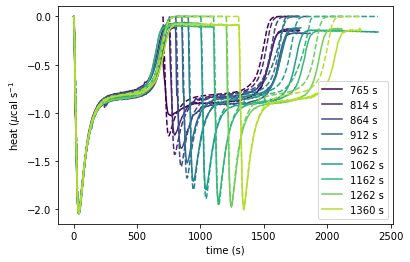

In [31]:
DataR100=Data['R100']
thr=60
E0=100e-3
S0=180
TR=[765, 814, 864, 912, 962, 1062, 1162, 1262, 1360]
Cl=100
k0=23
k1=1.05
c=3.6#this is the value of c that best fits the data
k3=0.0095
k4=0.0059  
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,tf in enumerate(TR):
    D=DataR100[tf].dropna()
    ax.plot(D,color=cmap(i/len(TR)), label=str(tf)+' s')
    rD=realH(D)
    tf=tf-thr
    k2=getk2(rD[0:tf],c,E0)
    delay=37
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(TR)))
    #REACTIVATION
    delay=37
    Params=Parameters(k0,k1,k2,k3,k4,delay,E[-1])
    y0=[0,S0,C[-1],C2[-1]]
    #sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='RK45',t_eval=(range(len(D)-tf)),max_step=0.1,args=((Params,)))
    sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='Radau',t_eval=(range(len(D)-tf)),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs2=measuredH(T,H)
    ax.plot(T+tf,Hs2,ls='dashed',color=cmap(i/len(TR)))
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataR100_normal_delay.pdf', bbox_inches='tight')

Interestingly, the peak of released heat after reinjection is overestimated for the early injection times. This is because we have assumed that the delay in the reaction $C \rightarrow C_2$ gets restarted after reinjection. If we set the delay to zero after reinjection, we get the following:

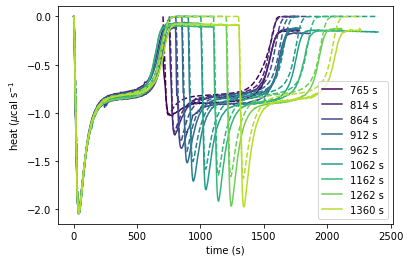

In [32]:
DataR100=Data['R100']
thr=60
E0=100e-3
S0=180
TR=[765, 814, 864, 912, 962, 1062, 1162, 1262, 1360]
Cl=100
k0=23
k1=1.05
c=3.6#this is the value of c that best fits the data
k3=0.0095
k4=0.0059  
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,tf in enumerate(TR):
    D=DataR100[tf].dropna()
    ax.plot(D,color=cmap(i/len(TR)), label=str(tf)+' s')
    rD=realH(D)
    tf=tf-thr
    k2=getk2(rD[0:tf],c,E0)
    delay=37
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(TR)))
    #REACTIVATION
    delay=0
    Params=Parameters(k0,k1,k2,k3,k4,delay,E[-1])
    y0=[0,S0,C[-1],C2[-1]]
    #sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='RK45',t_eval=(range(len(D)-tf)),max_step=0.1,args=((Params,)))
    sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='Radau',t_eval=(range(len(D)-tf)),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs2=measuredH(T,H)
    ax.plot(T+tf,Hs2,ls='dashed',color=cmap(i/len(TR)))
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataR100_no_delay.pdf', bbox_inches='tight')

So here the heat release peaks after reinjection are underestimated especially for the late reinjection times. This suggests that there is a mechanistic explanation behind the delay, whereby the "active" enzyme does not have any delay and starts getting transformed into $C_2$ immediately, but after some time without interacting with the substrate it requires some time before that reaction can take place. We will discuss later a possible chemical mechanism for this, but before that we will show that an *ad hoc* Hill function mimicking a delay that starts at zero and slowly grows up to 37 seconds captures the peaks much better than the previous figures.

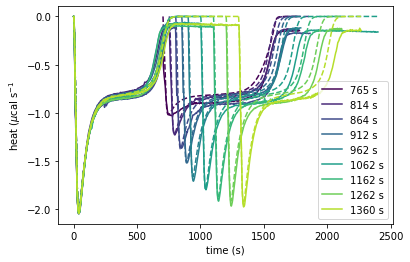

In [33]:
DataR100=Data['R100']
thr=60
E0=100e-3
S0=180
TR=[765, 814, 864, 912, 962, 1062, 1162, 1262, 1360]
Cl=100
k0=23
k1=1.05
c=3.6#this is the value of c that best fits the data
k3=0.0095
k4=0.0059  
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,tf in enumerate(TR):
    D=DataR100[tf].dropna()
    ax.plot(D,color=cmap(i/len(TR)), label=str(tf)+' s')
    rD=realH(D)
    tf=tf-thr
    k2=getk2(rD[0:tf],c,E0)
    delay=37
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(TR)))
    #REACTIVATION
    delay=37*(tf-705)/(tf-600)
    Params=Parameters(k0,k1,k2,k3,k4,delay,E[-1])
    y0=[0,S0,C[-1],C2[-1]]
    #sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='RK45',t_eval=(range(len(D)-tf)),max_step=0.1,args=((Params,)))
    sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='Radau',t_eval=(range(len(D)-tf)),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs2=measuredH(T,H)
    ax.plot(T+tf,Hs2,ls='dashed',color=cmap(i/len(TR)))
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataR100_progressive_delay.pdf', bbox_inches='tight')

## REACTIVATION AT 400mM CL 

This is very similar to the previous case:

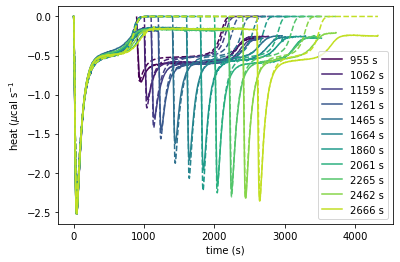

In [44]:
DataR400=Data['R400']
thr=60
E0=100e-3
S0=140
TR=[955, 1062, 1159, 1261, 1465, 1664, 1860, 2061, 2265, 2462, 2666]
Cl=400
k0=25
k1=1.05
c=4.5
k2=6.02
k3=0.01
k4=0.0025
delay=37
fig=plt.figure()
ax=plt.gca()
cmap=matplotlib.cm.get_cmap('viridis')
for i,tf in enumerate(TR):
    D=DataR400[tf].dropna()
    ax.plot(D,color=cmap(i/len(TR)), label=str(tf)+' s')
    rD=realH(D)
    tf=tf-thr
    k2=getk2(rD[0:tf],c,E0)
    delay=37
    Params=Parameters(k0,k1,k2,k3,k4,delay,E0)
    y0=[0,S0,0,0]
    sol=solve_ivp(oxa,(0,tf),y0,method='Radau',t_eval=range(tf),args=((Params,)))
    T=sol.t
    E=sol.y[0,:]
    C=sol.y[2,:]
    C2=sol.y[3,:]
    H=heat(c,Params.k2,C)
    Hs=measuredH(T,H)
    ax.plot(T,Hs,ls='dashed',color=cmap(i/len(TR)))
    #REACTIVATION
    delay=37*(tf-900)/(tf-700)
    Params=Parameters(k0,k1,k2,k3,k4,delay,E[-1])
    y0=[0,S0,C[-1],C2[-1]]
    #sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='RK45',t_eval=(range(len(D)-tf)),max_step=0.1,args=((Params,)))
    sol=solve_ivp(oxa,(0,len(D)-tf),y0,method='Radau',t_eval=(range(len(D)-tf)),args=((Params,)))
    T=sol.t
    C=sol.y[2,:]
    H=heat(c,Params.k2,C)
    Hs2=measuredH(T,H)
    ax.plot(T+tf,Hs2,ls='dashed',color=cmap(i/len(TR)))
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('heat ($\mu$cal s$^{-1}$')
fig.savefig('figures/suppfig_dataR400.pdf', bbox_inches='tight')